<a id='top'></a>
# STIS DrizzlePac Tutorial
_____________________________
## Learning Goals

By the end of this tutorial, you will:
- Learn how to download STIS data from [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) using [`astroquery`](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
- CTI correct STIS CCD data with the new pixel-based CTI code [`stis_cti`](https://pythonhosted.org/stis_cti/) (see [webpage](https://www.stsci.edu/hst/instrumentation/stis/data-analysis-and-software-tools/pixel-based-cti) for more details).
- Align images to sub-pixel accuracy for all three STIS detectors (CCD, NUV MAMA, FUV MAMA) using [`tweakreg`](https://drizzlepac.readthedocs.io/en/latest/tweakreg.html) from [DrizzlePac](https://drizzlepac.readthedocs.io/en/latest/index.html).
- Combine images using [`astrodrizzle`](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html) from [DrizzlePac](https://drizzlepac.readthedocs.io/en/latest/index.html).

## Introduction

The [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) instrument on board the _Hubble Space Telescope_ (HST) has three detectors: a charge-coupled device (CCD) and two multi-anode microchannel array (MAMA) detectors for near- and far-ultraviolet wavelengths (NUV MAMA and FUV MAMA respectively). The CCD detector suffers from charge transfer inefficiency (CTI) which can be corrected for directly on the CCD images using a pixel-based algorithm (`stis_cti`; based on work by [Anderson & Bedin 2010](https://ui.adsabs.harvard.edu/abs/2010PASP..122.1035A/abstract), see [webpage](https://www.stsci.edu/hst/instrumentation/stis/data-analysis-and-software-tools/pixel-based-cti)).

In order to maximize the science capabilities of images taken with STIS, they can be accurately aligned and combined (or 'drizzled'). The codes used to do this are from the DrizzlePac package which has been extensively tested on Wide-Field Camera 3 (WFC3) and Advanced Camera for Surveys (ACS) data but was previously unsupported for STIS. This tutorial gives alignment and drizzling examples for STIS images of standard star fields taken for each of its three detectors. We refer users to the [DrizzlePac Handbook](https://www.stsci.edu/scientific-community/software/drizzlepac.html) (Gonzaga et al. 2015, Hoffmann et al. 2021) for more details on the drizzling process and DrizzlePac codes.

### STIS Data Formats

**CCD data:** For this example, only post-SM4 CCD data taken on primary science amplifier D are used. These are the best calibrated STIS CCD images, the default for science observations, and can be CTI corrected with the new pixel-based code `stis_cti`. For alignment and drizzling, we use STIS CCD images that have been fully calibrated (sx2.fits images: dark- and bias-subtracted, flat-fielded, sky-subtracted, summed individual cosmic-ray (CR) split images with CR-rejection and distortion corrections already applied) that have also been CTI corrected (s2c.fits images).

**MAMA data:** MAMA detectors do not require CTI corrections or CR-rejection, and STIS MAMA imaging is typically taken in single exposures (i.e., not CR split). For this example, we only use MAMA data with one science extension (i.e., three extensions total: `SCI`, `ERR`, `DQ`) as is typical for STIS MAMA data. If the MAMA data has more than one science extension (`NEXTEND>3`), the science extensions can be summed and saved as a new fits file with this as the first (and only) science extension. These should also be available as sfl.fits images from MAST where this is relevant. For alignment and drizzling, we use STIS MAMA images that have been fully calibrated (x2d.fits:  dark- and bias-subtracted, flat-fielded, sky-subtracted, distortion corrections already applied).

Typically `tweakreg` and `astrodrizzle` require individual dark- and bias-subtracted, flat-fielded images (flt.fits), as for WFC3 and ACS. For STIS data, a few workarounds are required to ensure these codes can run on the STIS data. Additionally, specific parameters are set to ensure that additional calibrations (e.g, sky subtraction, CR-rejection, distortion corrections) are not applied to the already calibrated STIS data.

See the [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisihb) and [STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb) (specifically [Section 2.2](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-2-types-of-stis-files) on file types) for more information.

______________________
## Setting up the Conda Environment

The following commands may be used to reproduce the Python environment used to generate and test this Notebook.

- Create a base conda environment and activate it
    - `conda create --name stiscti_phot python=3.7.10 astropy=4.2.1 astroquery=0.4 crds=10.3.11 hstcal=2.7.1 ipython jupyterlab matplotlib numpy=1.20.2 pandas=1.3.1 pyyaml setuptools=52.0.0 six=1.16.0 stistools=1.3.0 stsci.tools=3.6.0 pysynphot=1.0.0 photutils=1.0.2 stwcs=1.6.1`
    - `source activate stiscti_phot`
    
- Pip install DrizzlePac:
    - `pip install drizzlepac` (this will get DrizzlePac v3.2.1 and above, only v3.1.8 with bugs available via conda as of Aug 2021)
    
- Install STIS specific codes for the CTI correction with [`stis_cti`](https://pythonhosted.org/stis_cti/qsg.html):
    - Load STIS conda environment: `source activate stiscti_phot` 
    - Move into a software directory e.g.: `cd /user/your_username/software/`
    - Clone repos: 
        - `git clone https://github.com/spacetelescope/refstis.git`    (version 0.8.1 used)
        - `git clone https://github.com/spacetelescope/stis_cti.git`   (version 1.4 used)
    - Install STIS packages:
        - `cd refstis`
        - `python setup.py install`
        - `cd stis_cti`
        - `python setup.py install`
____________________
## Imports

- _os_ for operating system commands
- _sys_ to set system preferences
- _glob_ for getting file names
- _shutil_ for copying files
- _subprocess_ for running system commands in the Notebook
- _numpy_ to handle array functions
- _pandas_ for dataframe storage and manipulation
- _matplotlib.pyplot_ for plotting images
- _tempfile TemporaryDirectory_ for creating temporary storage directories while downloading and sorting data
- _astropy.io fits_ for working with FITS files
- _astropy.io ascii_ for working with ascii files
- _astropy.table Table_ for creating tidy tables
- _astropy.visualization ZScaleInterval_ for scaling images for display
- _stis_cti_ for CTI correcting STIS data
- _drizzlepac_ for alignment (_tweakreg_) and image drizzling (_astrodrizzle_)
- _astroquery_ for querying and downloading data from MAST
- _copy_files_ custom function (in directory) for creating directories, checking for data and copying files

In [ ]:
# Notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load packages
import os
import sys
import glob
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.visualization import ZScaleInterval

# STIS packages
from stis_cti import stis_cti, archive_dark_query
from stis_cti import __version__ as stis_cti_version
print (f'stis_cti v{stis_cti_version}')

# STScI packages
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle as ad
from astroquery.mast import Observations

# Custom package, copy_files.py should be in the same directory
import copy_files as cf

In [2]:
# Set plotting defaults
matplotlib.rcParams['figure.figsize'] = [15, 5]
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.aspect'] = 'equal'
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['image.interpolation'] = 'none'
%matplotlib inline

# Setting pandas display options
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set numpy array display options
np.set_printoptions(threshold=sys.maxsize)

__________________
## Set & Make Directories
Set root directory for project (`root_dir`), a reference file directory (`ref_dir`, explained in more detail below but set this path to any existing reference file directories if present), and a cache directory for temporary data storage for downloads (``cache_dir``). The remaining directories will be nested within the root directory and are created below. 

In [3]:
def check_mkdir(new_dir):
    """Check for and make directory.
    
    Function to check for a directory and make it if it doesn't exist.
    
    Parameters
    ----------
    new_dir : str
        Path of directory to check for/make.
    
    """
    
    # Check for directory
    if os.path.exists(new_dir):
        print('Directory exists: {}'.format(new_dir))
    else:
        # Make directory
        os.makedirs(new_dir, 0o774)
        print('Created directory: {}'.format(new_dir))

In [4]:
# Get the Notebook current working directory to handle relative paths
cwd = os.getcwd()

# Set temporary data download store
cache_dir = './data_cache'         # Update this as needed

# Set the reference file directory
ref_dir = './reference_files'      # Update this if another reference file directory exists

# Set root and data directories
root_dir = './drizpac'              # Update this as needed
dat_dir = os.path.join(root_dir, 'data')
ccd_dir = os.path.join(dat_dir, 'ccd_data')
mama_dir = os.path.join(dat_dir, 'mama_data')

# Set directories for CTI correction of CCD data
cti_dir = os.path.join(dat_dir, 'ccd_cti')
science = os.path.join(cti_dir, 'science')
darks = os.path.join(cti_dir, 'darks')
ref_cti = os.path.join(cti_dir, 'ref')

# Set directories for alignment with tweakreg
ccd_twk = os.path.join(dat_dir, 'ccd_twk')
nuv_twk = os.path.join(dat_dir, 'nuv_twk')
fuv_twk = os.path.join(dat_dir, 'fuv_twk')

# Set directories for drizzling with astrodrizzle
ccd_drz = os.path.join(dat_dir, 'ccd_drz')
nuv_drz = os.path.join(dat_dir, 'nuv_drz')
fuv_drz = os.path.join(dat_dir, 'fuv_drz')

# Check for directories and make them if they don't exist
for d in [cache_dir, ref_dir, root_dir, dat_dir, ccd_dir, mama_dir, cti_dir, science, darks, ref_cti, ccd_twk, fuv_twk, nuv_twk, ccd_drz, fuv_drz, nuv_drz]:
    check_mkdir(d)

Created directory: ./data_cache
Created directory: ./reference_files
Created directory: ./drizpac
Created directory: ./drizpac/data
Created directory: ./drizpac/data/ccd_data
Created directory: ./drizpac/data/mama_data
Created directory: ./drizpac/data/ccd_cti
Created directory: ./drizpac/data/ccd_cti/science
Created directory: ./drizpac/data/ccd_cti/darks
Created directory: ./drizpac/data/ccd_cti/ref
Created directory: ./drizpac/data/ccd_twk
Created directory: ./drizpac/data/fuv_twk
Created directory: ./drizpac/data/nuv_twk
Created directory: ./drizpac/data/ccd_drz
Created directory: ./drizpac/data/fuv_drz
Created directory: ./drizpac/data/nuv_drz


## Setting Up Reference File Directory

STScI codes (e.g., `stis_cti`, `DrizzlePac`) need to access reference files to ensure the HST data they run on are properly calibrated. A local store for the reference files is required and a systerm variable should be set for the codes to access those files. The directory variable for STIS data is called "`oref`" by convention. 

We create the `oref` environment variable first and populate it with the necessary reference files later in the Notebook. If you already have the required STIS reference files in an existing `oref` directory, set the `oref` environment variable to that directory path.

We can assign a system variable in three different ways, depending on whether we are working from:

1. The command line
2. A Python/Jupyter environment
3. A Jupyter Notebook

|Unix-style Command Line| Python/Jupyter | Jupyter Notebook|
|-|-|-|
|  export oref='./reference_files/references/...'  |  os.environ[\'oref\'] = \'./reference_files/references/...\' |  %env oref ./reference_files/references/...  |

Note that this system variable must be set again with every new instance of a terminal or Notebook or the `export` command can be added to your `.bash_profile` or equivalent file.

The [Calibration Reference Data System (CRDS)](https://hst-crds.stsci.edu/) both stores the reference files and determines the mapping of reference files to observations. The `crds` tool can find, update, and download the best reference files for a particular observation. The [documentation for `crds`](https://hst-crds.stsci.edu/static/users_guide/index.html) describes many of the more advanced options. In this Notebook we provide a demonstration on how to obtain updated reference file information stored in the FITS headers of observations and download those files to a local reference file directory.

First the following environment variables are needed:
- `CRDS_SERVER_URL`: Location of the CRDS server.
- `CRDS_PATH`: Path to where reference files will be downloaded.
- `oref`: Path that the reference files will be downloaded to within `CRDS_PATH`

In [5]:
# Set environment variables
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(ref_dir)
os.environ['oref'] = os.path.join(os.path.abspath(ref_dir), 'references', 'hst', 'stis') + os.path.sep   # Trailing slash important
# print('oref: {}'.format(os.environ['oref']))

## Downloading Data
The data used in this example are from STIS monitoring observations of two standard star fields: NGC 5139 for the CCD and NGC 6681 for the MAMAs. We use two programs for each field from 2010 and 2011. The data are taken at the same position angle (PA) with some dithering and in the following filters:
- CCD: 50CCD
- NUV MAMA: F25SRF2, F25QTZ, F25CN182
- FUV MAMA: F25SRF2, F25QTZ, 25MAMA

The data are downloaded from [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) using [`astroquery`](https://astroquery.readthedocs.io/en/latest/mast/mast.html), ~288 MB of data for the CCD and ~437 MB of data for the MAMAs.

In [6]:
# Set proposal IDs (PIDs)
ccd_pids = [11854, 12409]
mama_pids = [11856, 12413]    # Both NUV & FUV MAMA observations taken in a single PID

In [7]:
# Check astroquery Observations options
Observations.get_metadata("observations")
Observations.get_metadata("products")

<Table length=34>
     Column Name      ...
        str21         ...
--------------------- ...
           intentType ...
       obs_collection ...
      provenance_name ...
      instrument_name ...
              project ...
              filters ...
    wavelength_region ...
          target_name ...
target_classification ...
               obs_id ...
                  ... ...
             s_region ...
              jpegURL ...
             distance ...
                obsid ...
           dataRights ...
               mtFlag ...
               srcDen ...
              dataURL ...
        proposal_type ...
      sequence_number ...

<Table length=18>
       Column Name         ...
          str26            ...
-------------------------- ...
                    obs_id ...
                     obsID ...
            obs_collection ...
          dataproduct_type ...
               description ...
                   dataURI ...
                      type ...
   productGroupDescription ...
   productDocumentationURL ...
productSubGroupDescription ...
               proposal_id ...
              parent_obsid ...
                      size ...
                   project ...
           productFilename ...
               productType ...
                prvversion ...
               calib_level ...

In [8]:
def get_oids(pids):
    """Get observation IDs from proposal IDs.
    
    From a list of input proposal IDs (``pids``) get a list of observation IDs 
    (``oids``) using astroquery.

    Parameters
    ----------
    pids : list or array_like of str or int
        List or array of proposal IDs to find observation IDs for
        
    Returns
    -------
    oids : list of str
        List of observation IDs within the input proposal IDs
    
    """
    
    oids = []
    
    # For each PID get obs IDs
    for pid in pids:
        obs = Observations.query_criteria(proposal_id='{}'.format(pid))    
        products = Observations.get_product_list(obs)
        oids += list(np.unique(products['obs_id']))
    
    print('{} observation IDs found for {} proposal IDs'.format(len(oids), len(pids)))
    return oids

# Get the obs_id values from the PIDs
ccd_oids  = get_oids(ccd_pids)
mama_oids = get_oids(mama_pids)

18 observation IDs found for 2 proposal IDs
36 observation IDs found for 2 proposal IDs


In [9]:
def download_data(ids, destination, product_types=None, cache_dir=cache_dir):
    '''Downloads MAST data products into a flattened location.
    
    Downloads data products (``product_type``) from input observation IDs (``ids``) 
    from MAST and copies them to a single directory (``destination``) from the 
    temporary download directory (``cache_dir``). Similar to stisteam.getdata(). 
    Written by Sean Lockwood.
    
    Parameters
    ----------
    ids : list of str
        List of observation IDs to download data products from
    destination : str
        Full path to final destination directory for data
    product_types : list of str, optional
        Names of product types to download for each observation ID (default is None, 
        means all data products will be downloaded)
    cache_dir : str, optional
        Full path to temporary data download storage directory (default 
        ``cache_dir`` as defined above)
    
    '''
    
    assert os.path.isdir(destination), 'Destination must be a directory'
    
    print('\nDownloading & copying data to {}\n'.format(destination))

    # Get data products for each observation ID
    obs = Observations.query_criteria(obs_id=ids)    
    products = Observations.get_product_list(obs)
    if product_types is not None:
        products = products[[x.upper() in product_types for x in products['productSubGroupDescription']]]
    
    # Download data and combine into the destination directory
    with TemporaryDirectory(prefix='downloads', dir=cache_dir) as d:
        dl = Observations.download_products(products, mrp_only=False, download_dir=d)
        for filename in dl['Local Path']:
            shutil.copy(filename, destination)

In [10]:
# Download and combine CCD data (~288 MB)
download_data(ccd_oids, ccd_dir, product_types={'RAW', 'EPC', 'SPT', 'ASN', 'SX2'})

# Download and combine MAMA data (~437 MB)
download_data(mama_oids, mama_dir, product_types = {'X2D'})

## Download Reference Files

The reference files for the STIS images are then updated in the image headers and downloaded (~250 MB). While the `crds.bestrefs` tool is also accessible inside of Python, it was designed with a command line interface in mind, therefore it is easiest to use it this way.

In [11]:
# Find and update the headers with the best reference files and download them
def download_ref_files(image_list):
    print('Downloading reference files for:\n{}\n'.format(image_list))
    images = ' '.join(image_list)
    subprocess.check_output('crds bestrefs --files {} --sync-references=1 --update-bestrefs'.format(images), shell=True, stderr=subprocess.DEVNULL)

# Check in the Notebook directory
os.chdir(cwd)

# Get a list of images for the CCD and download reference files
ccd_list = glob.glob(os.path.join(ccd_dir, '*_raw.fits'))
download_ref_files(ccd_list)

# Get a list of images for the MAMAs and download reference files
mama_list = glob.glob(os.path.join(mama_dir, '*_x2d.fits'))
download_ref_files(mama_list)

['./drizpac/data/ccd_data/obat01080_raw.fits', './drizpac/data/ccd_data/obmj01080_raw.fits', './drizpac/data/ccd_data/obmj01090_raw.fits', './drizpac/data/ccd_data/obat01040_raw.fits', './drizpac/data/ccd_data/obmj01020_raw.fits', './drizpac/data/ccd_data/obat01060_raw.fits', './drizpac/data/ccd_data/obat01070_raw.fits', './drizpac/data/ccd_data/obmj01010_raw.fits', './drizpac/data/ccd_data/obat01090_raw.fits', './drizpac/data/ccd_data/obmj01070_raw.fits', './drizpac/data/ccd_data/obmj01060_raw.fits', './drizpac/data/ccd_data/obat01010_raw.fits', './drizpac/data/ccd_data/obmj01040_raw.fits', './drizpac/data/ccd_data/obat01050_raw.fits', './drizpac/data/ccd_data/obmj01030_raw.fits', './drizpac/data/ccd_data/obat01020_raw.fits', './drizpac/data/ccd_data/obat01030_raw.fits', './drizpac/data/ccd_data/obmj01050_raw.fits']

['./drizpac/data/mama_data/obmi01y6q_x2d.fits', './drizpac/data/mama_data/obmi01yeq_x2d.fits', './drizpac/data/mama_data/obmi01ymq_x2d.fits', './drizpac/data/mama_data/ob

## CTI Correct CCD Images

A pixel-based CTI correction is applied to the STIS CCD data with [`stis_cti`](https://pythonhosted.org/stis_cti/). At present, this code can only be run on post-Servicing Mission 4 (SM4 in 2009) CCD data taken on the default science amplifier D. For all other CCD data, the previous empricial method ([`stistools.ctestis`](https://stistools.readthedocs.io/en/latest/ctestis.html)) can be used.

First the necessary files are copied over to the CTI correction directory. Then the darks needed to correct the data are determined and downloaded (about ~1.2 GB of data). Then the `stis_cti` code is run, see this [webpage](https://pythonhosted.org/stis_cti/stis_cti.html#stis-cti-stis-cti) for a full description of the parameters. The `num_processes` parameter is the maximum number of parallel processes to use when running `stis_cti`, adjust this as needed for your machine.

In [12]:
# Set file extensions for CCD image data to copy
exts = ['*_raw.fits', '*_epc.fits', '*_spt.fits', '*_asn.fits']

# Copy over all CCD files for each extension to the CTI correction directory
os.chdir(cwd)
for ext in exts:
    cf.copy_files_check(ccd_dir, science, files='{}'.format(ext))

18 files to copy from ./drizpac/data/ccd_data to ./drizpac/data/ccd_cti/science
Destination directory exists: ./drizpac/data/ccd_cti/science
Copying ./drizpac/data/ccd_data/obat01080_raw.fits to ./drizpac/data/ccd_cti/science/obat01080_raw.fits
Copying ./drizpac/data/ccd_data/obmj01080_raw.fits to ./drizpac/data/ccd_cti/science/obmj01080_raw.fits
Copying ./drizpac/data/ccd_data/obmj01090_raw.fits to ./drizpac/data/ccd_cti/science/obmj01090_raw.fits
Copying ./drizpac/data/ccd_data/obat01040_raw.fits to ./drizpac/data/ccd_cti/science/obat01040_raw.fits
Copying ./drizpac/data/ccd_data/obmj01020_raw.fits to ./drizpac/data/ccd_cti/science/obmj01020_raw.fits
Copying ./drizpac/data/ccd_data/obat01060_raw.fits to ./drizpac/data/ccd_cti/science/obat01060_raw.fits
Copying ./drizpac/data/ccd_data/obat01070_raw.fits to ./drizpac/data/ccd_cti/science/obat01070_raw.fits
Copying ./drizpac/data/ccd_data/obmj01010_raw.fits to ./drizpac/data/ccd_cti/science/obmj01010_raw.fits
Copying ./drizpac/data/ccd_

In [13]:
# Determine dark exposures required for CCD data and download them (~1.2 GB)
needed_darks = archive_dark_query(glob.glob(os.path.join(science, '*_raw.fits')))

dark_exposures = set()
for anneal in needed_darks:
    for dark in anneal['darks']:
        dark_exposures.add(dark['exposure'])

download_data(dark_exposures, darks, product_types={'FLT', 'EPC', 'SPT'})

Querying MAST archive for dark and anneal program IDs...
Querying MAST archive for darks...
Parsing archive results...

Download darks via this link:

https://archive.stsci.edu/hst/search.php?sci_instrume=STIS&sci_instrument_config=STIS%2FCCD&sci_targname=DARK&sci_aec=C&resolve=don%27tresolve&sci_data_set_name=OB8XBDFXQ%2COB8XBEG1Q%2COB8XBFKBQ%2COB8XBGKJQ%2COB8XBHPFQ%2COB8XBIPQQ%2COB8XBJV3Q%2COB8XBKV8Q%2COB8XBLYPQ%2COB8XBMZ2Q%2COB8XBNEJQ%2COB8XBOEQQ%2COB8XBPBRQ%2COB8XBQC6Q%2COB8XBRFXQ%2COB8XBSGAQ%2COB8XBTNDQ%2COB8XBUQ0Q%2COB8XBVU0Q%2COB8XBWX5Q%2COB8XBXZFQ%2COB8XBYBXQ%2COB8XBZDZQ%2COB8XC0H4Q%2COB8XC1IGQ%2COB8XC2L4Q%2COB8XC3BNQ%2COB8XC4C2Q%2COB8XC5GJQ%2COB8XC6GTQ%2COB8XC7MJQ%2COB8XC8MVQ%2COB8XC9RCQ%2COB8XCARKQ%2COB8XCBVOQ%2COB8XCCW1Q%2COB8XCDAOQ%2COB8XCEAXQ%2COB8XCFF5Q%2COB8XCGFSQ%2COB8XCHE5Q%2COB8XCIA1Q%2COB8XCJHPQ%2COB8XCKHUQ%2COB8XCLN9Q%2COB8XCMNKQ%2COB8XCNR4Q%2COB8XCOR8Q%2COB8XCPX0Q%2COB8XCQXOQ%2COB8XCRCWQ%2COB8XCSD3Q%2COB8XCTGCQ%2COB8XCUGTQ%2COB8XCVA3Q%2COB8XCWAKQ%2COBN24PEBQ%2COBN2

In [ ]:
# Run the CTI code on the CCD data
stis_cti(
    science_dir=os.path.abspath(science),
    dark_dir=os.path.abspath(darks),
    ref_dir=os.path.abspath(ref_cti),
    num_processes=15,
    verbose=2,)

Run checks on and inspect the CCD CTI corrected images.

In [15]:
# Print information for each file, check those that have been CTI corrected
os.chdir(cwd)
files = glob.glob(os.path.join(os.path.abspath(science), '*raw.fits'))
files.sort()

psm4 = 0
ampd = 0
ampo = 0
for f in files:
    
    # Open file header
    hdr = fits.getheader(f, 0)
    
    # Get year obs
    yr = int(hdr['TDATEOBS'].split('-')[0])
    
    # Get file info
    if yr <= 2004: 
        print('\n...PRE-SM4 ({}), NOT CTE CORRECTED...'.format(yr))
        psm4 += 1
    elif os.path.exists(f.replace('raw.fits', 'cte.fits')): 
        print('\n***CTE CORRECTED, AMP {} ({})***'.format(hdr['CCDAMP'], yr))
        ampd += 1
    else: 
        ampo +=1
        print('\n~NON-CTE CORRECTED, AMP {} ({})~'.format(hdr['CCDAMP'], yr))
    print('FILE: {}, PID: {}, ROOT: {}'.format(os.path.basename(f), hdr['PROPOSID'], hdr['ROOTNAME']))
    print('INST: {}, DETECTOR: {}, AP: {}'.format(hdr['INSTRUME'], hdr['DETECTOR'], hdr['APERTURE']))
    print('DATE OBS:{}, PROCESSED: {}'.format(hdr['TDATEOBS'], hdr['DATE']))


***CTE CORRECTED, AMP D (2010)***
FILE: obat01010_raw.fits, PID: 11854, ROOT: obat01010
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSED: 2021-09-24

***CTE CORRECTED, AMP D (2010)***
FILE: obat01020_raw.fits, PID: 11854, ROOT: obat01020
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSED: 2021-09-24

***CTE CORRECTED, AMP D (2010)***
FILE: obat01030_raw.fits, PID: 11854, ROOT: obat01030
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSED: 2021-09-24

***CTE CORRECTED, AMP D (2010)***
FILE: obat01040_raw.fits, PID: 11854, ROOT: obat01040
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSED: 2021-09-24

***CTE CORRECTED, AMP D (2010)***
FILE: obat01050_raw.fits, PID: 11854, ROOT: obat01050
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSED: 2021-09-24

~NON-CTE CORRECTED, AMP C (2010)~
FILE: obat01060_raw.fits, PID: 11854, ROOT: obat01060
INST: STIS, DETECTOR: CCD, AP: 50CCD
DATE OBS:2010-01-30, PROCESSE

In [16]:
# Run checks on data
nraw = len(glob.glob(os.path.join(science, '*raw.fits')))
ncte = len(glob.glob(os.path.join(science, '*cte.fits')))
print('{} raw CCD files, {} CTE corrected files'.format(nraw, ncte))   # Should be equal if all data taken on amp D and post-SM4
print('{} pre-SM4, {} amp D (CTE corr), {} other amp (non-CTE)'.format(psm4, ampd, ampo))

18 raw CCD files, 10 CTE corrected files
0 pre-SM4, 10 amp D (CTE corr), 8 other amp (non-CTE)


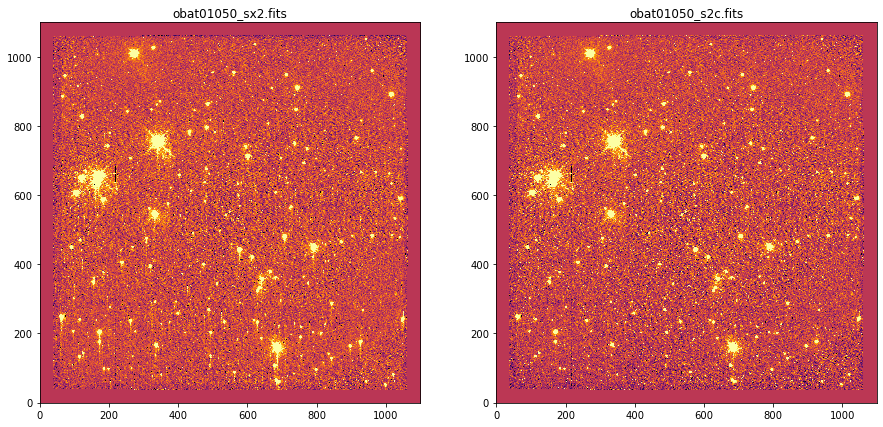

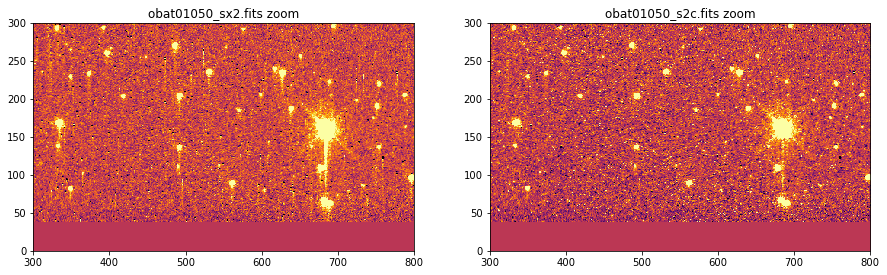

In [17]:
# Display example CCD images
sci_root = 'obat01050'
sx2_file = os.path.join(ccd_dir, '{}_sx2.fits'.format(sci_root))   # CR rejected, distortion corrected
s2c_file = os.path.join(science, '{}_s2c.fits'.format(sci_root))   # CR rejected, distortion corrected, CTI corrected

ccd_files = [sx2_file]
cti_files = [s2c_file]

for ccdf, ctif in zip(ccd_files, cti_files):
    
    # Plot whole image
    fig, axes = plt.subplots(1, 2)
    _=fig.set_size_inches(15, 7)

    vmin, vmax = -10, 10
    for filename, ax in zip([ccdf, ctif], axes):
        _=ax.imshow(fits.getdata(filename, ext=1), vmin=vmin, vmax=vmax)
        _=ax.set_title(os.path.basename(filename))
    plt.show()

    # Zoom in near the bottom center
    fig, axes = plt.subplots(1, 2)
    _=fig.set_size_inches(15, 7)

    vmin, vmax = -10, 10
    for filename, ax in zip([ccdf, ctif], axes):
        _=ax.imshow(fits.getdata(filename, ext=1), vmin=vmin, vmax=vmax)
        _=ax.set_title('{} zoom'.format(os.path.basename(filename)))
        _=ax.set_xlim(300, 800)
        _=ax.set_ylim(0, 300)
    plt.show()

## File Information

Information is pulled from file headers and combined into a dataframe. The information is used for file sorting and determining appropriate alignment and drizzle parameters. We select only CCD data taken with primary science amplifier D and MAMA data with only one science extension for this example (see the **Introduction - STIS Data Formats** section for more details).

In [18]:
# Make dataframe of image properties
os.chdir(cwd)
det_dirs = [science, mama_dir]
exts = ['*_s2c.fits', '*_x2d.fits']

# Set variable arrays
fnames = []
det_names = []
rnames = []
pids = []
yrs = []
tdats = []
dats = []
dets = []
aps = []
nexs = []
texps = []
amps = []
gains = []
pas = []
ras = []
decs = []
pt1s = []
pt2s = []

# Loop over folders and file extensions
for det_dir, ext in zip(det_dirs, exts):
    
    # Get list of file names
    files = glob.glob(os.path.join(det_dir, ext))
    files.sort()
    
    # Loop over each file
    for f in files:
        # Open file header
        hdr = fits.getheader(f, 0) + fits.getheader(f, 1)

        # Get image properties
        fname = os.path.basename(f)
        rname = hdr['ROOTNAME'].strip()
        pid = hdr['PROPOSID']
        yr = int(hdr['TDATEOBS'].split('-')[0])
        tdat = hdr['TDATEOBS'].strip()
        dat = hdr['DATE'].strip().split('T')[0]
        det = hdr['DETECTOR'].strip()
        nex = hdr['NEXTEND']
        texp = hdr['TEXPTIME']
        ap = hdr['APERTURE'].strip()
        pa = hdr['PA_APER']
        ra = hdr['RA_TARG']
        dec = hdr['DEC_TARG']
        pt1 = hdr['POSTARG1']
        pt2 = hdr['POSTARG2']

        # For CCD data, store different header information
        if 'CCD' in det:
            amp = hdr['CCDAMP'].strip()
            gain = hdr['CCDGAIN']
            
            # For CCD data, only using amp D data (i.e., the only data that is CTI corrected)
            if 'D' in amp:
                if ext == '*_s2c.fits': det_name = 'ccd_cti'
                else: det_name = 'ccd'
            else: 
                # Name excluded CCD files
                if ext == '*_s2c.fits': det_name = 'xccd_cti'
                else: det_name = 'xccd'

        # Store detector name for MAMAs
        elif 'MAMA' in det: 
            
            # Take only single SCI exposure MAMA files (i.e. 3 extensions, SCI, ERR, DQ)
            if nex == 3:
                if 'FUV-MAMA' in det: det_name = 'fuv_mama'
                elif 'NUV-MAMA' in det: det_name = 'nuv_mama'
            else: 
                if 'FUV-MAMA' in det: det_name = 'xfuv_mama'
                elif 'NUV-MAMA' in det: det_name = 'xnuv_mama'
            
            # MAMAs do not have amp or gain info
            amp = '-'
            gain = '-'
        
        # Save file info
        fnames.append(fname)
        det_names.append(det_name)
        rnames.append(rname)
        pids.append(pid)
        yrs.append(yr)
        tdats.append(tdat)
        dats.append(dat)
        dets.append(det)
        aps.append(ap)
        nexs.append(nex)
        texps.append(texp)
        amps.append(amp)
        gains.append(gain)
        pas.append(pa)
        ras.append(ra)
        decs.append(dec)
        pt1s.append(pt1)
        pt2s.append(pt2)

# Create data frame of image properties
df = pd.DataFrame({})
df['file'] = fnames
df['type'] = det_names
df['rootname'] = rnames
df['pid'] = pids
df['year_obs'] = yrs
df['date_obs'] = tdats
df['date_proc'] = dats
df['detector'] = dets
df['aperture'] = aps
df['nextend'] = nexs
df['texptime'] = texps
df['amp'] = amps
df['gain'] = gains
df['pa_aper'] = pas
df['ra'] = ras
df['dec'] = decs
df['postarg1'] = pt1s
df['postarg2'] = pt2s
df = df.sort_values(by=["type", "date_obs"]).reset_index(drop=True)
df

file      type   rootname    pid  year_obs    date_obs   date_proc  detector  aperture  nextend  texptime amp gain     pa_aper          ra        dec   postarg1   postarg2
0   obat01010_s2c.fits   ccd_cti  obat01010  11854      2010  2010-01-30  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980622  201.404333 -47.593972   0.000000   0.000000
1   obat01020_s2c.fits   ccd_cti  obat01020  11854      2010  2010-01-30  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980622  201.404333 -47.593972   0.506985   0.253879
2   obat01030_s2c.fits   ccd_cti  obat01030  11854      2010  2010-01-30  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980813  201.404333 -47.593972   0.760246   0.761174
3   obat01040_s2c.fits   ccd_cti  obat01040  11854      2010  2010-01-30  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980706  201.404333 -47.593972   0.253261   0.507295
4   obat01050_s2c.fits   ccd_cti  obat01050  11854      2010  2010-01-30  2022-04-14       CCD     50CCD        3      60.0   D    4  -94.980622  201.404333 -47.593972   0.000000   0.000000
5   obmj01010_s2c.fits   ccd_cti  obmj01010  12409      2011  2011-02-05  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980622  201.404333 -47.593972   0.000000   0.000000
6   obmj01020_s2c.fits   ccd_cti  obmj01020  12409      2011  2011-02-05  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980622  201.404333 -47.593972   0.506985   0.253879
7   obmj01030_s2c.fits   ccd_cti  obmj01030  12409      2011  2011-02-05  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980813  201.404333 -47.593972   0.760246   0.761174
8   obmj01040_s2c.fits   ccd_cti  obmj01040  12409      2011  2011-02-05  2022-04-14       CCD     50CCD        3      10.0   D    4  -94.980706  201.404333 -47.593972   0.253261   0.507295
9   obmj01050_s2c.fits   ccd_cti  obmj01050  12409      2011  2011-02-05  2022-04-14       CCD     50CCD        3      60.0   D    4  -94.980622  201.404333 -47.593972   0.000000   0.000000
10  obav01w4q_x2d.fits  fuv_mama  obav01w4q  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    25MAMA        3     400.0   -    - -138.947169  280.803375 -32.292667   0.000000   0.000000
11  obav01w6q_x2d.fits  fuv_mama  obav01w6q  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    25MAMA        3     400.0   -    - -138.945842  280.803375 -32.292667  10.000000   0.000000
12  obav01w8q_x2d.fits  fuv_mama  obav01w8q  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    25MAMA        3     400.0   -    - -138.946986  280.803375 -32.292667  10.000000  10.000000
13  obav01waq_x2d.fits  fuv_mama  obav01waq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    25MAMA        3     400.0   -    - -138.948314  280.803375 -32.292667   0.000000  10.000000
14  obav01wdq_x2d.fits  fuv_mama  obav01wdq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    F25QTZ        3     400.0   -    - -138.947769  280.803375 -32.292667   0.000000   0.000000
15  obav01wpq_x2d.fits  fuv_mama  obav01wpq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA   F25SRF2        3     400.0   -    - -138.947969  280.803375 -32.292667   0.000000   0.000000
16  obav01wtq_x2d.fits  fuv_mama  obav01wtq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    25MAMA        3     400.0   -    - -138.947169  280.803375 -32.292667   0.000000   0.000000
17  obav01wwq_x2d.fits  fuv_mama  obav01wwq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA    F25QTZ        3     400.0   -    - -138.947769  280.803375 -32.292667   0.000000   0.000000
18  obav01wzq_x2d.fits  fuv_mama  obav01wzq  11856      2010  2010-05-07  2021-09-24  FUV-MAMA   F25SRF2        3     400.0   -    - -138.947969  280.803375 -32.292667   0.000000   0.000000
19  obmi01y4q_x2d.fits  fuv_mama  obmi01y4q  12413      2011  2011-04-16  2021-09-25  FUV-MAMA    25MAMA        3     400.0   -    - -138.947169  280.803375 -32.292667   0.000000   0.000000
20  obmi01y6q_x2d.fits  fuv_

In [19]:
# Get exposure times to aid with determining alignment parameters
print('\nCCD-CTI CORRECTED EXP TIMES ({} files)'.format(len(df.loc[df['type']=='ccd_cti'])))
np.sort(df['texptime'].loc[df['type']=='ccd_cti'].unique())

print('\nNUV MAMA EXP TIMES ({} files)'.format(len(df.loc[df['type']=='nuv_mama'])))
np.sort(df['texptime'].loc[df['type']=='nuv_mama'].unique())

print('\nFUV MAMA EXP TIMES ({} files)'.format(len(df.loc[df['type']=='fuv_mama'])))
np.sort(df['texptime'].loc[df['type']=='fuv_mama'].unique())


CCD-CTI CORRECTED EXP TIMES (10 files)


array([10., 60.])


NUV MAMA EXP TIMES (18 files)


array([300.])


FUV MAMA EXP TIMES (18 files)


array([400.])

In [20]:
# Check for directories, make them if they don't exist, copy files to alignment directories
os.chdir(cwd)
cf.copy_files_check(science, ccd_twk, files=df['file'].loc[df['type']=='ccd_cti'])    # s2c: Distortion+CR+CTI corrected CCD
cf.copy_files_check(mama_dir, nuv_twk, files=df['file'].loc[df['type']=='nuv_mama'])  # x2d: Distortion corrected NUV-MAMA
cf.copy_files_check(mama_dir, fuv_twk, files=df['file'].loc[df['type']=='fuv_mama'])  # x2d: Distortion corrected FUV-MAMA

10 files to copy from ./drizpac/data/ccd_cti/science to ./drizpac/data/ccd_twk
Destination directory exists: ./drizpac/data/ccd_twk
Copying ./drizpac/data/ccd_cti/science/obat01010_s2c.fits to ./drizpac/data/ccd_twk/obat01010_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obat01020_s2c.fits to ./drizpac/data/ccd_twk/obat01020_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obat01030_s2c.fits to ./drizpac/data/ccd_twk/obat01030_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obat01040_s2c.fits to ./drizpac/data/ccd_twk/obat01040_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obat01050_s2c.fits to ./drizpac/data/ccd_twk/obat01050_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obmj01010_s2c.fits to ./drizpac/data/ccd_twk/obmj01010_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obmj01020_s2c.fits to ./drizpac/data/ccd_twk/obmj01020_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obmj01030_s2c.fits to ./drizpac/data/ccd_twk/obmj01030_s2c.fits
Copying ./drizpac/data/ccd_cti/science/obmj0

## Image Alignment
Use `tweakreg` to align the images from the three STIS detectors to sub-pixel accuracy.

### Tips and Tricks for Using [tweakreg](https://drizzlepac.readthedocs.io/en/latest/tweakreg.html)

- For `tweakreg` to work on the already distortion-corrected STIS data, it needs the missing header keyword `IDCSCALE` ('default' plate scale for the detector) as done below.
- `tweakreg` can align images to better than 0.1 pixel accuracy but it can vary between ~0.05-0.5 pixels depending on the image/number of sources/relative alignment to the reference image etc.
- **NOTE:** `tweakreg` changes the image headers after each run, unless `updatehdr=False` is set. Therefore, for testing alignment parameters, always use `updatehdr=False` until happy with the parameters. For the final run, set `updatehdr=True` to update the image headers with their new WCS solution ready for drizzling.
- Select a good quality reference image, e.g., a deeper exposure, roughly centered within the area covered by the other images, no obvious issues/contamination.
- Testing of parameters should, to first order, improve the accuracy of alignment (`XRMS/YRMS` parameters). But don't rely on this value alone to verify the quality of fit.
- Pixel shifts (`XSH/YSH` parameters) between images can range between 0-30 pixels (maybe up to 50 pixels). Expected shifts can be sanity checked by eye with an image viewer (e.g. DS9). Very large shifts (100s pixels) likely indicate a false solution.
- The number of sources found in images and used for alignment is less important than the quality of the sources used. See the **Testing Alignment Parameters** section below for code to overplot the sources used for alignment on the images.
- Below are common parameters to adjust to align images ([input image params](https://drizzlepac.readthedocs.io/en/latest/imagefindpars.html)/[reference image params](https://drizzlepac.readthedocs.io/en/latest/refimagefindpars.html)), trial and error is best for honing in on a solution:
    - `threshold`: sigma limit above background for source detection.
        - Note that sigma is highly image dependent and can vary widely (e.g. from 0.5 to 200 for the same image and get similar results). It is worth exploring a wide parameter space to find an initial solution.
    - `minobj`: Minimum number of objects to be matched between images. 
        - 10 is a reasonable lower limit, sometimes lower is needed (e.g. for FUV MAMA with fewer sources) but be warned of going too low and false detections/solutions will be found
    - `peakmax`: Sets a maximum value of sources in the image. 
        - Useful for selecting bright stars (needed in FUV-MAMA with so few sources) or avoiding saturated stars.
    - `use_sharp_round=True`: Select well-defined sources.
    - `conv_width`: Convultion kernel width, recommended 2x the PSF FWHM. 
        - Sometimes for lower quality/blurrier images this has to be increased to find a solution.
    - `searchrad`: Search radius for a match (default units arcsec). 
        - Sometimes you need to increase this by quite a bit to find a solution. Default 1, but you can use up to 10-20 depending on images.
- There are many more parameters to explore but reasonable alignment solutions should be obtainable for most STIS images with some combination of these.
- If you need to re-run `tweakreg` on already tweaked images (ran with `updatehdr=True`), make a fresh directory and copy over clean files again using the cell above (`copy_files_check`).

In [21]:
# Add in missing header keyword 'IDCSCALE' for tweakreg to work on STIS images

# Set tweak directories, file extensions and detector names
twk_dirs = [ccd_twk, nuv_twk, fuv_twk]
exts = ['*_s2c.fits', '*_x2d.fits', '*_x2d.fits']
dets = ['CCD', 'NUV MAMA', 'FUV MAMA']

# Loop over each detector
for twk_dir, ext, det in zip(twk_dirs, exts, dets):
    os.chdir(cwd)
    os.chdir(os.path.abspath(twk_dir))
    print('Updating headers for {} files in {}'.format(ext, twk_dir))
    
    # Loop over each file
    for i, f in enumerate(glob.glob(ext)):
        hdu = fits.open(f, 'update')
        
        # Set 'default' plate scale for the detector
        if det == 'CCD': idc = 0.05072
        elif det == 'NUV MAMA': idc = 0.0246037
        elif det == 'FUV MAMA': idc = 0.024395
        
        # Create keyword in header and save
        hdu[1].header['IDCSCALE'] = idc
        hdu.close()

Updating headers for *_s2c.fits files in ./drizpac/data/ccd_twk
Updating headers for *_x2d.fits files in ./drizpac/data/nuv_twk
Updating headers for *_x2d.fits files in ./drizpac/data/fuv_twk


### Select Reference Images
Based on the dataframe of image properties in the **File Summary** section, identify an appropriate reference image (`ref_img`) for each detector (see **Tips and Tricks for Using tweakreg** section above). Adjust `tweakreg` parameters per detector to accurately align images onto the reference image. **Set `update=False` for testing and change to `update=True` for final run to update image headers.**

In [22]:
# Set the reference files for each detector
ccd_ref = 'obat01050_s2c.fits'
nuv_ref = 'obav01v9q_x2d.fits'
fuv_ref = 'obav01w4q_x2d.fits'

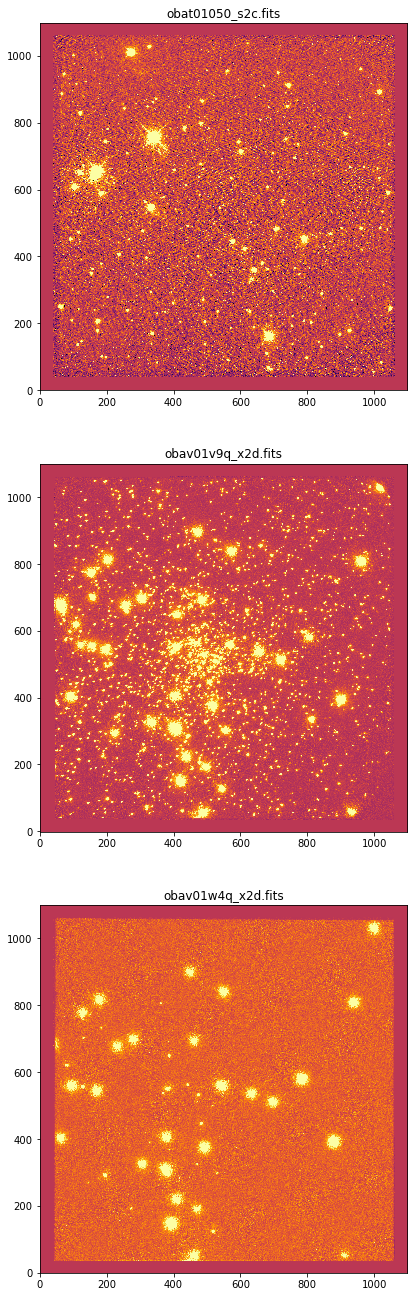

In [23]:
# Set the reference image paths
os.chdir(cwd)
cref = os.path.join(ccd_twk, ccd_ref)
nref = os.path.join(nuv_twk, nuv_ref)
fref = os.path.join(fuv_twk, fuv_ref)

# Plot reference images
fig, axes = plt.subplots(3, 1)
_=fig.set_size_inches(7, 23)

vmin, vmax = -10, 10
for filename, ax in zip([cref, nref, fref], axes):
    _=ax.imshow(fits.getdata(filename, ext=1), vmin=vmin, vmax=vmax)
    _=ax.set_title(os.path.basename(filename))
plt.show()


### CCD (CTI Corrected) Image Alignment

Parameters tested for a couple of different exposure times are given below: <=10s and 60s. 

Alignment accuracy for these images ranges between ~0.04--0.2 pixels, with average ~0.11 pixels.

./drizpac/data/ccd_twk

Aligning 9 *_s2c.fits files to obat01050_s2c.fits: ['obat01010_s2c.fits', 'obat01020_s2c.fits', 'obat01030_s2c.fits', 'obat01040_s2c.fits', 'obmj01010_s2c.fits', 'obmj01020_s2c.fits', 'obmj01030_s2c.fits', 'obmj01040_s2c.fits', 'obmj01050_s2c.fits']


+++++++++++++++++++++++++++++++++++++++++++++++++++
FILE (1/9): obat01010_s2c.fits, ROOT: obat01010, TEXP:10.0
MINOBJ: 5, THRESH-IMG: 1.7, THRESH-REF: 1.0, PEAKMAX:1500, CONVW: 3.5
+++++++++++++++++++++++++++++++++++++++++++++++++++

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 12:53:22.304 (14/04/2022) 

Version Information
--------------------
Python Version [GCC 7.5.0]
3.7.10 (default, Jun  4 2021, 14:48:32) 
numpy Version -> 1.20.2 
astropy Version -> 4.2.1 
stwcs Version -> 1.6.1 

Finding shifts for: 
    obat01010_s2c.fits

===  Source finding for image 'obat01010_s2c.fits':
  #  Source finding for 'obat01010_s2c.fits', EXT=('SCI', 1) started at: 12:53:22.368 (14/04/20

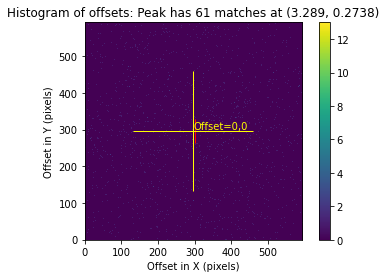

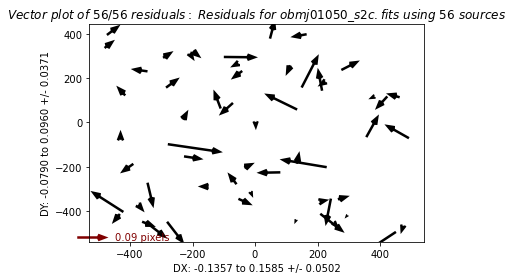

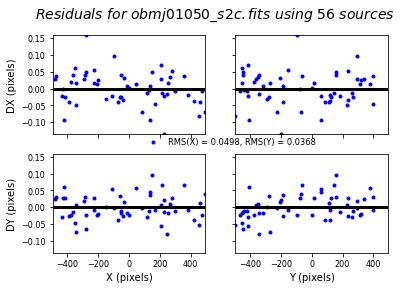

In [24]:
# -------------------
# CCD - CTI CORRECTED
# -------------------

# Keep flag as FALSE until happy with parameters
# Set to TRUE for final run
update = False

# Move into tweak directory
os.chdir(cwd)
os.chdir(ccd_twk)
print(ccd_twk)

# Set reference image and extension name
ref_img = ccd_ref
ext = '*_s2c.fits'

# Set files to align to reference image (remove ref image from list)
files = glob.glob(ext)
files.remove(ref_img)
files.sort()
print('\nAligning {} {} files to {}: {}\n'.format(len(files), ext, ref_img, files))

# Loop over files, get image info, set parameters, align
for i, f in enumerate(files):
    
    # Get file info
    print('\n+++++++++++++++++++++++++++++++++++++++++++++++++++')
    hdr = fits.getheader(f, 0)
    texp = hdr['TEXPTIME']
    print('FILE ({}/{}): {}, ROOT: {}, TEXP:{}'.format(i+1, len(files), f, hdr['ROOTNAME'], texp))
    
    # Set params based on exposure time, print details
    if texp <= 10: minobj, ithresh, rthresh, peak, convw = 5, 1.7, 1.0, 1500, 3.5      # tested for <=10s CCD exposures
    elif texp == 60: minobj, ithresh, rthresh, peak, convw = 10, 1.7, 1.0, 900, 3.5     # tested for 60s CCD exposures
    print('MINOBJ: {}, THRESH-IMG: {}, THRESH-REF: {}, PEAKMAX:{}, CONVW: {}'.format(minobj, ithresh, rthresh, peak, convw))
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
    # Run tweakreg for each file
    tweakreg.TweakReg(f, updatehdr=update, conv_width=convw, shiftfile=True, outshifts='{}_shifts.txt'.format(hdr['ROOTNAME']),
                      refimage=ref_img, clean=False, interactive=False, minobj=minobj, 
                      searchrad=15.0, imagefindcfg={'threshold':ithresh, 'peakmax':peak, 'use_sharp_round':True},
                      refimagefindcfg={'threshold':rthresh, 'peakmax':peak, 'use_sharp_round':True})

### NUV MAMA Image Alignment

Parameters tested for a couple of different exposure times are given below as a guide: 300 to <1000s (used here) and >=1000s. For other 300s images spanning 25 years of STIS data (only two programs used here), adjusting the convolution width (e.g., `conv_width=4.5, 5.5, 6.5`) for specific files enabled an alignment solution to be found. One file (obmi01xqq_x2d.fits in `ofiles`) has an offset from the reference image and required different parameters to find an alignment solution.

Alignment accuracy for these images ranges between ~0.1--0.5 pixels, with average ~0.3 pixels. These values are higher than the CCD partly due to the larger number of sources and that the MAMA data span three filters. 

./drizpac/data/nuv_twk

Aligning 17 *_x2d.fits files to obav01v9q_x2d.fits: ['obav01vaq_x2d.fits', 'obav01vcq_x2d.fits', 'obav01veq_x2d.fits', 'obav01vgq_x2d.fits', 'obav01viq_x2d.fits', 'obav01vkq_x2d.fits', 'obav01vmq_x2d.fits', 'obav01w1q_x2d.fits', 'obmi01xlq_x2d.fits', 'obmi01xmq_x2d.fits', 'obmi01xoq_x2d.fits', 'obmi01xqq_x2d.fits', 'obmi01xsq_x2d.fits', 'obmi01xuq_x2d.fits', 'obmi01xwq_x2d.fits', 'obmi01y0q_x2d.fits', 'obmi01y2q_x2d.fits']


++++++++++++++++++++++++++++++++++++++++++++++++++++++
FILE (1/17): obav01vaq_x2d.fits, ROOT: obav01vaq, TEXP:300.0
MINOBJ: 10, THRESH-IMG: 0.7, THRESH-REF: 0.5, PEAKMAX:500, CONVW: 5.5
++++++++++++++++++++++++++++++++++++++++++++++++++++++

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 12:53:47.575 (14/04/2022) 

Version Information
--------------------
Python Version [GCC 7.5.0]
3.7.10 (default, Jun  4 2021, 14:48:32) 
numpy Version -> 1.20.2 
astropy Version -> 4.2.1 
stwcs Version -> 1.6.1 

Finding

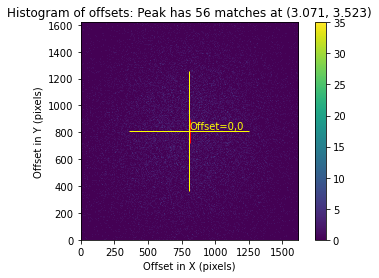

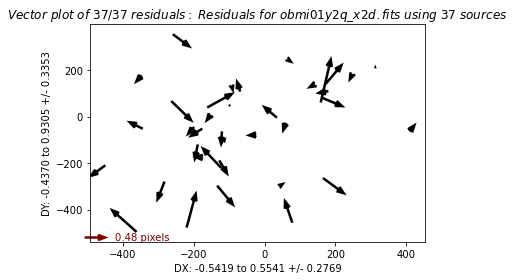

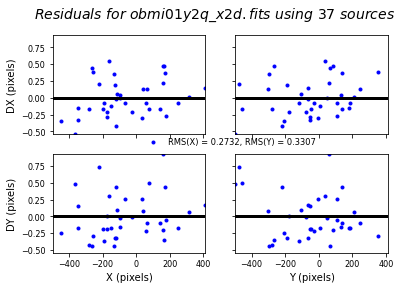

In [25]:
# -------------------
# NUV MAMA
# -------------------

# Keep flag as FALSE until happy with parameters
# Set to TRUE for final run
update = False

# Move into tweak directory
os.chdir(cwd)
os.chdir(nuv_twk)
print(nuv_twk)

# Set reference image and extension name
ref_img = nuv_ref
ext = '*_x2d.fits'

# Set files to align to reference image (remove ref image from list)
files = glob.glob(ext)
files.remove(ref_img)
files.sort()
ofiles = ['obmi01xqq_x2d.fits']  # file requiring different parameters
print('\nAligning {} {} files to {}: {}\n'.format(len(files), ext, ref_img, files))

# Loop over files, get image info, set parameters, align
for i, f in enumerate(files):
    
    # Get file info
    print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    hdr = fits.getheader(f, 0)
    texp = hdr['TEXPTIME']
    print('FILE ({}/{}): {}, ROOT: {}, TEXP:{}'.format(i+1, len(files), f, hdr['ROOTNAME'], texp))
    
    # Set params based on exposure time, print details
    if f in ofiles: minobj, ithresh, rthresh, peak, convw, sr = 10, 300, 200, 300, 4.5, 20
    else: minobj, ithresh, rthresh, peak, convw, sr = 10, 0.7, 0.5, 500, 5.5, 20            # tested for 300 to <1000s NUV MAMA exposures
    # minobj, ithresh, rthresh, peak, convw, sr = 10, 300, 200, 300, 4.5, 10                # tested for >=1000s NUV MAMA exposures
    print('MINOBJ: {}, THRESH-IMG: {}, THRESH-REF: {}, PEAKMAX:{}, CONVW: {}'.format(minobj, ithresh, rthresh, peak, convw))
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
    # Run tweakreg for each file
    tweakreg.TweakReg(f, updatehdr=update, conv_width=convw, shiftfile=True, outshifts='{}_shifts.txt'.format(hdr['ROOTNAME']),
                      refimage=ref_img, clean=False, interactive=False, minobj=minobj, 
                      searchrad=sr, imagefindcfg={'threshold':ithresh, 'peakmax':peak, 'use_sharp_round':True},
                      refimagefindcfg={'threshold':rthresh, 'peakmax':peak, 'use_sharp_round':True})

### FUV MAMA Image Alignment

Parameters tested for a couple of different exposure times are given below as a guide: 400s to <1000s (used here), and >=1000s. For other images spanning 25 years of STIS data (only two programs shown here), adjusting the convolution width (e.g., `conv_width=4.5, 5.5, 6.5`) for specific files enabled an alignment solution to be found. Two files (obmi01y8q_x2d.fits, obmi01yaq_x2d.fits in `ofiles`) have an offset from the reference image and required different parameters to find an alignment solution.

Alignment accuracy for these images ranges between ~0.1--0.4 pixels, with average ~0.18 pixels. These values are slightly higher than the CCD as the MAMA data span three filters and the FUV MAMA has a broader PSF. 

./drizpac/data/fuv_twk

Aligning 17 *_x2d.fits files to obav01w4q_x2d.fits: ['obav01w6q_x2d.fits', 'obav01w8q_x2d.fits', 'obav01waq_x2d.fits', 'obav01wdq_x2d.fits', 'obav01wpq_x2d.fits', 'obav01wtq_x2d.fits', 'obav01wwq_x2d.fits', 'obav01wzq_x2d.fits', 'obmi01y4q_x2d.fits', 'obmi01y6q_x2d.fits', 'obmi01y8q_x2d.fits', 'obmi01yaq_x2d.fits', 'obmi01yeq_x2d.fits', 'obmi01ygq_x2d.fits', 'obmi01yiq_x2d.fits', 'obmi01ykq_x2d.fits', 'obmi01ymq_x2d.fits']





++++++++++++++++++++++++++++++++++++++++++++++++++++++
FILE (1/17): obav01w6q_x2d.fits, ROOT: obav01w6q, TEXP:400.0
MINOBJ: 5, THRESH-IMG: 200, THRESH-REF: 50, PEAKMAX:3000, CONVW: 5.5
++++++++++++++++++++++++++++++++++++++++++++++++++++++

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 12:54:53.83 (14/04/2022) 

Version Information
--------------------
Python Version [GCC 7.5.0]
3.7.10 (default, Jun  4 2021, 14:48:32) 
numpy Version -> 1.20.2 
astropy Version -> 4.2.1 
stwcs Version -> 1.6.1 

Findin

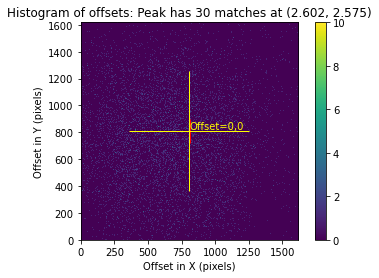

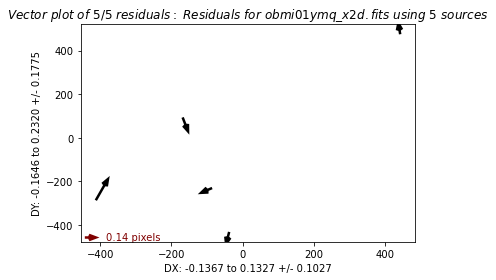

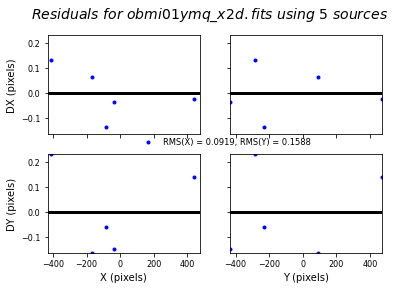

In [26]:
# -------------------
# FUV MAMA
# -------------------

# Keep flag as FALSE until happy with parameters
# Set to TRUE for final run
update = False

# Move into tweak directory
os.chdir(cwd)
os.chdir(fuv_twk)
print(fuv_twk)

# UPDATE: Set reference image and extension names
ref_img = fuv_ref
ext = '*_x2d.fits'

# Set files to align to reference image (remove ref image from list)
files = glob.glob(ext)
files.remove(ref_img)
files.sort()
ofiles = ['obmi01y8q_x2d.fits', 'obmi01yaq_x2d.fits']  # files requiring different parameters
print('\nAligning {} {} files to {}: {}\n\n'.format(len(files), ext, ref_img, files))

for i, f in enumerate(files):
    
    # Get file info
    print('\n\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    hdr = fits.getheader(f, 0)
    texp = hdr['TEXPTIME']
    print('FILE ({}/{}): {}, ROOT: {}, TEXP:{}'.format(i+1, len(files), f, hdr['ROOTNAME'], texp))
    
    # Set params based on exposure time, print details
    if f in ofiles: minobj, ithresh, rthresh, peak, convw = 5, 100, 100, 3000, 5.5
    else:  minobj, ithresh, rthresh, peak, convw = 5, 200, 50, 3000, 5.5             # tested for 400s to <1000s exposures
    # minobj, ithresh, rthresh, peak, convw = 10, 200, 50, 8000, 5.5                 # tested for >=1000s exposures
    print('MINOBJ: {}, THRESH-IMG: {}, THRESH-REF: {}, PEAKMAX:{}, CONVW: {}'.format(minobj, ithresh, rthresh, peak, convw))
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    
    # Run tweakreg for each file
    tweakreg.TweakReg(f, updatehdr=update, conv_width=convw, shiftfile=True, outshifts='{}_shifts.txt'.format(hdr['ROOTNAME']),
                      refimage=ref_img, clean=False, interactive=False, minobj=minobj, 
                      searchrad=20.0, imagefindcfg={'threshold':ithresh, 'peakmax':peak, 'use_sharp_round':True},
                      refimagefindcfg={'threshold':rthresh, 'peakmax':peak, 'use_sharp_round':True})

### Testing Alignment Parameters
Below is useful code for testing `tweakreg` alignment parameters. If an image has been able to be matched (even if `updatehdr=False`) a `<rootname>_shifts.txt` file will be created. This code can be used to plot the sources used for alignment on the input image. Use this to verify the quality of sources used for alignment.

./drizpac/data/ccd_twk
['obat01010', 'obat01020', 'obat01030', 'obat01040', 'obmj01010', 'obmj01020', 'obmj01030', 'obmj01040', 'obmj01050']
       file          dx   dy   rot   scale  xrms yrms
------------------ ----- ---- ----- ------- ---- ----
obat01010_s2c.fits -0.01 0.09 0.001 0.99994 0.11 0.21


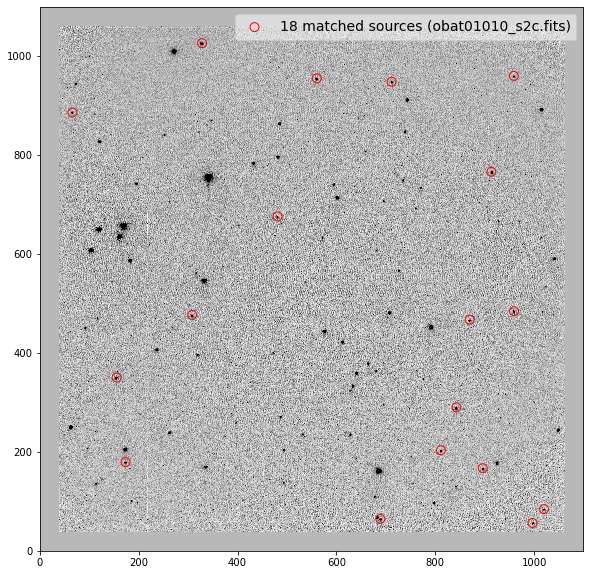

In [27]:
# Overplot sources used for alignment (written by Marc Rafelski)

# Set input directory, reference image and extension names (example for the CCD)
indir = ccd_twk
ref_img = ccd_ref
ext = '*_s2c.fits'

# Move into tweak directory
os.chdir(cwd)
os.chdir(indir)
print(indir)

# Set files to align to reference image (remove ref image from list)
files = glob.glob(ext)
files.remove(ref_img)
files.sort()

# Get rootnames of files
roots = [x.split('_')[0] for x in files]
print(roots)

# Loop over rootnames
for root in roots:
    # Set input file
    infile = '{}_shifts.txt'.format(root)

    # Read in table from tweakreg
    shift_tab=Table.read(infile, format='ascii.no_header', names=['file','dx','dy','rot','scale','xrms','yrms'])
    formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
    for i, col in enumerate(shift_tab.colnames[1:]):
        shift_tab[col].format = formats[i]
    shift_tab.pprint(max_lines=-1)
    
    # Overplot images with their alignment sources
    for image in shift_tab['file']:
        _=plt.figure(figsize = (10, 10))
        data = fits.open(image)['SCI', 1].data
        zscale = ZScaleInterval()
        z1, z2 = zscale.get_limits(data)
        _=plt.imshow(data, cmap='Greys',origin='lower', vmin=z1, vmax=z2)
        match_tab = ascii.read(image[0:13]+'_catalog_fit.match')
        x_cord, y_cord = match_tab['col11'], match_tab['col12']
        _=plt.scatter(x_cord, y_cord, s=80, edgecolor='r', facecolor='None', label='{} matched sources ({})'.format(len(match_tab),image))
        _=plt.legend(loc='upper right', fontsize=14, framealpha=0.5)
        plt.show()

## Drizzling Images

Next, the images for each detector are combined using `astrodrizzle`. The high-level concept behind drizzling images is described in detail in [Section 3.2 of the DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac/files/60245881/109774911/1/1642098151920/DrizzlePac_Handbook_v2.pdf). 

Setting the appropriate `final_scale` and `final_pixfrac` parameters for your images takes some thought and testing to avoid gaps in the data. The figure below shows a basic example of the native pixel scale (red squares), shrink factor `final_pixfrac` (blue squares) and output final pixel scale `final_scale` (grid on right) in a drizzle. For more details on the `astrodrizzle` input parameters, see the the [DrizzlePac code webpages](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html).
<img src="drizzle.png" alt="Drizzle" style="width: 600px;"/>

`astrodrizzle` can be used to increase the pixel sampling of data if images have dithering and different position angles (PAs). For the STIS data used here, all images are at the same PA and therefore sub-sampling the data is not possible. The example for the STIS data shown below adopts the native pixel scale of each detector as the `final_scale` and no fractional scaling down of each pixel (`final_pixfrac=1.0`) prior to drizzling. Drizzle in this context is a useful tool for creating mosaics of images aligned with `tweakreg`.

To ensure that `astrodrizzle` does not apply additional calibrations to the already calibrated STIS data, Steps 1-6 can be 'switched off' using the appropriate keywords (see [`astrodrizzle` webpage](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html) for keyword information). The CCD data are already CR-rejected and the MAMA data don't require this step, therefore many of those first steps (and their associated keywords) are to do with appropriately applying CR-rejection. Therefore the 'minmed' warning is not important for the STIS images.

Only data in a single filter for each detector are combined in this example: 50CCD (CCD), F25SRF2 (NUV MAMA), 25MAMA (FUV MAMA). STIS data have cleaned edges after the distortion correction is applied in the `calstis` pipeline. These are adaptively cropped out with the `crop_edges` function defined below for each image to avoid gaps in the final mosaics.

`astrodrizzle` changes the input image files, so it's advisable to first copy the data to a clean directory prior to drizzling (as done below). If you need to repeat the drizzling process, it's good practice to make another clean directory prior to running `astrodrizzle`.

In [28]:
# Copy over aligned images to a drizzle directory (creates direc. and copies files), single filters for MAMAs
os.chdir(cwd)
cf.copy_files_check(ccd_twk, ccd_drz, files=df['file'].loc[df['type']=='ccd_cti'])
cf.copy_files_check(nuv_twk, nuv_drz, files=df['file'].loc[(df['type']=='nuv_mama') & (df['aperture']=='F25SRF2')])  # x2d: Distortion corrected NUV-MAMA
cf.copy_files_check(fuv_twk, fuv_drz, files=df['file'].loc[(df['type']=='fuv_mama') & (df['aperture']=='25MAMA')])  # x2d: Distortion corrected FUV-MAMA

10 files to copy from ./drizpac/data/ccd_twk to ./drizpac/data/ccd_drz
Destination directory exists: ./drizpac/data/ccd_drz
Copying ./drizpac/data/ccd_twk/obat01010_s2c.fits to ./drizpac/data/ccd_drz/obat01010_s2c.fits
Copying ./drizpac/data/ccd_twk/obat01020_s2c.fits to ./drizpac/data/ccd_drz/obat01020_s2c.fits
Copying ./drizpac/data/ccd_twk/obat01030_s2c.fits to ./drizpac/data/ccd_drz/obat01030_s2c.fits
Copying ./drizpac/data/ccd_twk/obat01040_s2c.fits to ./drizpac/data/ccd_drz/obat01040_s2c.fits
Copying ./drizpac/data/ccd_twk/obat01050_s2c.fits to ./drizpac/data/ccd_drz/obat01050_s2c.fits
Copying ./drizpac/data/ccd_twk/obmj01010_s2c.fits to ./drizpac/data/ccd_drz/obmj01010_s2c.fits
Copying ./drizpac/data/ccd_twk/obmj01020_s2c.fits to ./drizpac/data/ccd_drz/obmj01020_s2c.fits
Copying ./drizpac/data/ccd_twk/obmj01030_s2c.fits to ./drizpac/data/ccd_drz/obmj01030_s2c.fits
Copying ./drizpac/data/ccd_twk/obmj01040_s2c.fits to ./drizpac/data/ccd_drz/obmj01040_s2c.fits
Copying ./drizpac/dat

In [29]:
def crop_edges(dq, cut=0.2):
    """Crop edges of distortion-corrected STIS data.
    
    Function to crop edges of a distortion-corrected STIS image using its data
    quality (DQ) array to avoid gaps in the drizzled mosaics. Function makes cuts 
    at intervals across the array (default fractions of ``cut=0.2``) and determines 
    the first and last instance of "good" data (DQ=0). The good data footprints in 
    DQ arrays are not perfectly square due to distortion corrections, hence multiple 
    cuts are made to find the smallest region of good data in both the x and y 
    directions to avoid partial data rows/columns. Function returns the indices in y 
    (``ymin``, ``ymax``) and x (``xmin``, ``xmax``) to crop the STIS image data with.
    
    Parameters
    ----------
    dq : ndarray
        DQ array of image to crop
    cut : float, optional
        Value between 0 and 1, fractional step sizes across array (default 0.2 means 
        cuts through data will be at fractions 0.2, 0.4, 0.6, 0.8 of each axis)

    Returns
    -------
    ymin : int
        Lower index of y axis to crop by
    ymax : int
        Upper index of y axis to crop by
    xmin : int
        Lower index of x axis to crop by
    xmax : int
        Upper index of x axis to crop by
    
    """
    
    # Set storage arrays
    ylos = []
    yhis = []
    xlos = []
    xhis = []
    
    # Make several cuts through the data
    for i in np.arange(0,1, cut)[1:]:
        
        # Find the index of the row/column
        val = int(dq.shape[0]*i)
        
        # Get start and end indices of the "good" data (DQ=0) in x & y 
        ylos.append(np.where(dq[:,val]==0)[0][0])
        yhis.append(np.where(dq[:,val]==0)[0][-1])
        xlos.append(np.where(dq[val,:]==0)[0][0])
        xhis.append(np.where(dq[val,:]==0)[0][-1])

    # Get crop indices: smallest region of good data to avoid partial data rows/columns
    ymin, ymax, xmin, xmax = np.max(ylos), np.min(yhis)+1, np.max(xlos), np.min(xhis)+1
    print('Cropping indices y= {}:{},  x= {}:{}\n'.format(ymin, ymax, xmin, xmax))  
    return ymin, ymax, xmin, xmax

### CCD (CTI Corrected) Image Drizzling

The CCD images are all observed at a common position angle and RA/Dec with small dithers (hence poorer quality edges in the mosaic below). Sub-sampling the images with `astrodrizzle` is not advisable for these programs as reducing the pixel size results in gaps in the data.

Figure shows the CCD drizzle of NGC 5139 (left) and the individual CCD reference image used for alignment (right).
<img src="ccd_drz.png" alt="CCD Drizzle" style="width: 600px;"/>

In [30]:
# Drizzling images together
# Move into drizzle directory
os.chdir(cwd)
os.chdir(ccd_drz)
print(ccd_drz)

# Set image extension names
ext = '*_s2c.fits'

# Set files to drizzle
files = glob.glob(ext)

# Get pixel scales from images and crop data
ps = []
for i, f in enumerate(files):
    # Read in HDU list and header
    print('\n{}'.format(f))
    hdu = fits.open(f, mode='update')
    hdr = hdu[0].header + hdu[1].header
    
    # Get all image pixel scales (can change slightly between headers)
    ps.append(hdr['PLATESC'])
    
    # Find cropping indices from DQ array
    dq = hdu[3].data
    ymin, ymax, xmin, xmax = crop_edges(dq)
    
    # Crop data down in each extension to remove edges with no data (from STIS distortion corrections)
    for j in np.arange(3):
        hdu[j+1].data = hdu[j+1].data[ymin:ymax, xmin:xmax]
        hdu[j+1].header['NAXIS1'] = hdu[j+1].data.shape[1]
        hdu[j+1].header['NAXIS2'] = hdu[j+1].data.shape[0]
    
    # Update primary header array size information
    hdu[0].header['SIZAXIS1'] = hdu[j+1].data.shape[1]
    hdu[0].header['SIZAXIS2'] = hdu[j+1].data.shape[0]
        
    # Save changes and close
    hdu.close()

# Set drizzle parameters
fs = np.min(np.array(ps))   # Final pixel scale (arcsec) of the output image, native pixel scale: ~0.050777
fp = 1.0                    # Fraction by which to shrink the input pixels prior to drizzling onto output grid

# Drizzle images together
ad.AstroDrizzle(files, static=False, skysub=False, driz_separate=False, median=False, blot=False, 
                driz_cr=False, driz_combine=True, clean=True, build=False, preserve=False, 
                final_scale=fs, final_pixfrac=fp, final_wht_type='ERR', output='ccd_drz')

./drizpac/data/ccd_drz

obat01030_s2c.fits
Cropping indices y= 56:1043,  x= 68:1049


obmj01050_s2c.fits
Cropping indices y= 56:1041,  x= 68:1049


obmj01030_s2c.fits
Cropping indices y= 56:1041,  x= 68:1049


obat01020_s2c.fits
Cropping indices y= 56:1043,  x= 68:1049


obat01050_s2c.fits
Cropping indices y= 56:1043,  x= 68:1049


obat01010_s2c.fits
Cropping indices y= 56:1043,  x= 68:1049


obmj01020_s2c.fits
Cropping indices y= 56:1041,  x= 68:1049


obat01040_s2c.fits
Cropping indices y= 56:1043,  x= 68:1049


obmj01010_s2c.fits
Cropping indices y= 56:1041,  x= 68:1049


obmj01040_s2c.fits
Cropping indices y= 56:1041,  x= 68:1049

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.2.1 (2021-02-16 08:51:21 -0500) started at: 12:55:55.720 (14/04/2022)

==== Processing Step  Initialization  started at  12:55:55.723 (14/04/2022)

##############################################################################
#                                                                   

### NUV MAMA Image Drizzling

The NUV images are all observed at a common position angle with large dithers (hence different image depths in the mosaic below). Sub-sampling the images with `astrodrizzle` is not advisable for these programs as reducing the pixel size results in gaps in the data.

Figure shows the NUV drizzle of NGC 6681 (left) and the individual NUV reference image used for alignment (right).

<img src="nuv_drz.png" alt="NUV Drizzle" style="width: 600px;"/>

In [31]:
# Drizzling images together
# Move into drizzle directory
os.chdir(cwd)
os.chdir(nuv_drz)
print(nuv_drz)

# Set image extension names
ext = '*_x2d.fits'

# Set files to drizzle
files = glob.glob(ext)

# Get pixel scales from images and crop data
ps = []
for i, f in enumerate(files):
    # Read in HDU list and header
    print('{}'.format(f))
    hdu = fits.open(f, mode='update')
    hdr = hdu[0].header + hdu[1].header
    
    # Get all image pixel scales (can change slightly between headers)
    ps.append(hdr['PLATESC'])
    
    # Find cropping indices from DQ array
    dq = hdu[3].data
    ymin, ymax, xmin, xmax = crop_edges(dq)
    
    # Crop data down in each extension to remove edges with no data (from STIS distortion corrections)
    for j in np.arange(3):
        hdu[j+1].data = hdu[j+1].data[ymin:ymax, xmin:xmax]
        hdu[j+1].header['NAXIS1'] = hdu[j+1].data.shape[1]
        hdu[j+1].header['NAXIS2'] = hdu[j+1].data.shape[0]
    
    # Update primary header array size information
    hdu[0].header['SIZAXIS1'] = hdu[j+1].data.shape[1]
    hdu[0].header['SIZAXIS2'] = hdu[j+1].data.shape[0]
        
    # Save changes and close
    hdu.close()
    
# Set drizzle parameters
fs = np.min(np.array(ps))   # Final pixel scale (arcsec) of the output image, native pixel scale: ~0.02475
fp = 1.0                    # Fraction by which to shrink the input pixels prior to drizzling onto output grid

# Drizzle images together
ad.AstroDrizzle(files, static=False, skysub=False, driz_separate=False, median=False, blot=False, 
                driz_cr=False, driz_combine=True, clean=True, build=False, preserve=False, 
                final_scale=fs, final_pixfrac=fp, final_wht_type='ERR', output='nuv_drz')

./drizpac/data/nuv_drz
obmi01xoq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obmi01xqq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obmi01xmq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obav01vcq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obav01v9q_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obav01vaq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obav01vkq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obav01veq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obmi01xlq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

obmi01xwq_x2d.fits
Cropping indices y= 43:1057,  x= 49:1053

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.2.1 (2021-02-16 08:51:21 -0500) started at: 12:56:04.090 (14/04/2022)

==== Processing Step  Initialization  started at  12:56:04.092 (14/04/2022)

##############################################################################
#                                                                            #

### FUV MAMA Image Drizzling

The FUV images are all observed at a common position angle with large dithers (hence different image depths in the mosaic below). Sub-sampling the images with `astrodrizzle` is not advisable for these programs as reducing the pixel size results in gaps in the data.

Figure shows the FUV drizzle of NGC 6681 (left) and the individual FUV reference image used for alignment (right).
<img src="fuv_drz.png" alt="FUV Drizzle" style="width: 600px;"/>

In [32]:
# Drizzling images together
# Move into drizzle directory
os.chdir(cwd)
os.chdir(fuv_drz)
print(fuv_drz)

# Set image extension names
ext = '*_x2d.fits'

# Set files to drizzle
files = glob.glob(ext)

# Get pixel scales from images and crop data
ps = []
for i, f in enumerate(files):
    # Read in HDU list and header
    print('{}'.format(f))
    hdu = fits.open(f, mode='update')
    hdr = hdu[0].header + hdu[1].header
    
    # Get all image pixel scales (can change slightly between headers)
    ps.append(hdr['PLATESC'])
    
    # Find cropping indices from DQ array
    dq = hdu[3].data
    ymin, ymax, xmin, xmax = crop_edges(dq)
    
    # Crop data down in each extension to remove edges with no data (from STIS distortion corrections)
    for j in np.arange(3):
        hdu[j+1].data = hdu[j+1].data[ymin:ymax, xmin:xmax]
        hdu[j+1].header['NAXIS1'] = hdu[j+1].data.shape[1]
        hdu[j+1].header['NAXIS2'] = hdu[j+1].data.shape[0]
    
    # Update primary header array size information
    hdu[0].header['SIZAXIS1'] = hdu[j+1].data.shape[1]
    hdu[0].header['SIZAXIS2'] = hdu[j+1].data.shape[0]
        
    # Save changes and close
    hdu.close()

# Set drizzle parameters
fs = np.min(np.array(ps))   # Final pixel scale (arcsec) of the output image, native pixel scale: ~0.024742
fp = 1.0                    # Fraction by which to shrink the input pixels prior to drizzling onto output grid

# Drizzle images together
ad.AstroDrizzle(files, static=False, skysub=False, driz_separate=False, median=False, blot=False, 
                driz_cr=False, driz_combine=True, clean=True, build=False, preserve=False, 
                final_scale=fs, final_pixfrac=fp, final_wht_type='ERR', output='fuv_drz')

./drizpac/data/fuv_drz
obmi01y6q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obmi01yaq_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obav01wtq_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obav01w4q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obmi01y8q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obmi01yiq_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obmi01y4q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obav01w6q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obav01waq_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

obav01w8q_x2d.fits
Cropping indices y= 41:1058,  x= 45:1054

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.2.1 (2021-02-16 08:51:21 -0500) started at: 12:56:13.655 (14/04/2022)

==== Processing Step  Initialization  started at  12:56:13.657 (14/04/2022)

##############################################################################
#                                                                            #

## About this Notebook

**Author:** Laura Prichard, Staff Scientist II, STIS Team.

**Written**: 2022-03-22

For questions on using the DrizzlePac package with STIS data, contact the [HST Help Desk](https://stsci.service-now.com/hst) (help@stsci.edu).

## Citations

- [The DrizzlePac Handbook](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/drizzlepac-handbook.pdf): Hoffmann, S. L., Mack, J., et al., 2021, “The DrizzlePac Handbook”, Version, (Baltimore: STScI).
- [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisihb): Prichard, L., Welty, D. and Jones, A., et al. 2022 "STIS Instrument Handbook," Version 21.0, (Baltimore: STScI).
- [STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb): Sohn, S. T., et al., 2019, “STIS Data Handbook”, Version 7.0, (Baltimore: STScI).
- See [citing `astropy`](https://www.astropy.org/acknowledging.html)
_____________
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 